In [10]:
import sys

sys.path.append('./source/')
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate, stats
import scipy

import matplotlib.cm as cm
from numpy import fft
from scipy.interpolate import interp1d
from scipy import interpolate as intp
import importlib
import json

from source import plots
from source import prob_dists as pd
import pyfftlog as pfl

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%pwd

'/Users/runburg/github/dm_gal_substructure'

In [11]:
# n = 0
# importlib.reload(pd)
# importlib.reload(plots)
# params = {'R_G': 220, # Kpc
#           'd_solar': 8.5, # kpc
#           'psi': 40,
#           'M_min': 1.0e-2, # Msun
#           'M_max': 1.0e10, # Msun
#           'fwimp': 1.0,
#           'mean_params': {'a':77.4, 'b':0.87+0.31*n, 'c':-0.23-0.04*n},
#           'nside': 128,
#           'area_fermi': 2000.0, # cm^2
#           'n': n,
#           'log_flux_min': -15, # log10 photons/cm^2/yr
#           'log_flux_max': -5, # log10 photons/cm^2/yr
#           'N': 1000,
#           'log_k_min': -3,
# #           'log_k_min': 2,
#           'log_k_max': 6,
# #           'log_k_max': 6.5,
#           'N_k': 250000,
#           'psh_log_f_min': -5,
# #           'psh_log_f_min': -4.5,
# #           'psh_log_f_max': -4.7,
#           'psh_log_f_max': -3.5,
#           'N_psh': 500
#          }

# params['omega_pixel'] = 4.*np.pi/(12*params['nside']**2.) # sr
# p = params
# json.dump(p, open('source/n0.params', 'w'), indent=0)

In [12]:
p = json.load(open('source/n0.params', 'r'))
p

{'R_G': 220,
 'd_solar': 8.5,
 'psi': 40,
 'M_min': 0.01,
 'M_max': 10000000000.0,
 'fwimp': 1.7896346444957159,
 'mean_params': {'a': 77.4, 'b': 0.87, 'c': -0.23},
 'nside': 128,
 'area_fermi': 2000.0,
 'n': 0,
 'log_flux_min': -15,
 'log_flux_max': -5,
 'N': 2000,
 'log_k_min': -3,
 'log_k_max': 6,
 'N_k': 250000,
 'psh_log_f_min': -6,
 'psh_log_f_max': -3.0,
 'N_psh': 1000,
 'omega_pixel': 6.391586616190171e-05,
 'exposure': 5570.423008216337,
 'iso_flux_bg': 0.0008939106670451649,
 'gal_flux_bg_file': './output/gal_flux_bg.npy',
 'bg': 1,
 'beg': 1,
 'beta': 1.9}

In [71]:
fluxes = np.logspace(p['log_flux_min'], p['log_flux_max'], num=p['N']*2)
p1_vals = pd.p1(fluxes, **p)
# fig, _ = plots.check_fp1_plot(fluxes, p1_vals)
t = fluxes
a_t = p1_vals
a_t = np.sin(np.log(fluxes))

beta is 1.9


In [75]:
# Range of periodic interval
logtmin = p['log_flux_min']
# logtmax = 0.798 #2pi
# 5(2pi) #Longer range in r gives you a better reconstruction. 10\pi will give
# you a better reconstruction than 2\pi.
logtmax = p['log_flux_max']
# Number of points (Max 4096)
# 1000 points give you a fairly smooth distribution of af in frequency, f.
# However you can get a good, working fit for 300 points as well.
n = p['N']*2

# Order mu of Bessel function
mu = 0.5  # Choose -0.5 for cosine fourier transform

# Bias exponent: q = 0 is unbiased
# The unbiased transforms give better results as far as I checked.
q = 0
# Sensible approximate choice of f_c t_c
# The output and the reconstruction is sensitive to the choice of this value
# This value is found by trial and error. In this example, the input function
# is a simple sine function which is not smooth in frequency space (as it
# only has one frequency) because of this reason a better value of this
# quantity is not found by the function fhti. For functions smooth
# in both time and frequency domain, the fhti should return the best
# value of the f_c t_c.

ft = 0

# Tell fhti to change ft to low-ringing value
# WARNING: kropt = 3 will fail, as interaction is not supported
ftopt = 2

# Forward transform (changed from dir to tdir, as dir is a python fct)
tdir = 1

# Central point log10(t_c) of periodic interval
logtc = (logtmin + logtmax)/2

print(f"Central point of periodic interval at log10(t_c) = {logtc}")

# Central index (1/2 integral if n is even)
nc = (n + 1)/2.0

# Log-spacing of points
dlogt = (logtmax - logtmin)/n

dlnr = dlogt*np.log(10.0)

Central point of periodic interval at log10(t_c) = -10.0


In [76]:
# logtmin = -15
# logtmax = 5
# n = 4000
# mu = 0.5
# q = 0
# ft = 0
# ftopt = 2
# tdir = 1
# dlogt = (logtmax - logtmin)/n
# dlnr = dlogt*np.log(10.0)
# ft, xsave = pfl.fhti(n, mu, dlnr, q, kropt=ftopt)

# # original signal
# fluxes = np.logspace(logtmin, logtmax, num=n)
# a_t = np.sin(np.log(fluxes))

# # FT
# a_f = pfl.fftl(a_t.copy(), xsave, ft, tdir)

# # IFT
# a_tt = pfl.fftl(a_f.copy(), xsave, ft, -1)

In [77]:
ft, xsave = pfl.fhti(n, mu, dlnr, q, kropt=ftopt)

 kr changed to  1.0019008710373392


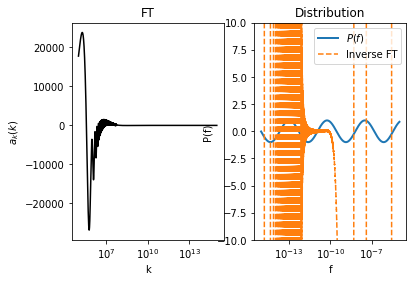

In [82]:
logfc = np.log10(ft) - logtc

# Fourier sine Transform
a_f = pfl.fftl(a_t.copy(), xsave, ft, tdir)
# Notice that np.sqrt(2/np.pi) is the normalization factor for the transform
# Reconstruct the input function by taking the inverse fourier transform as
# given in the description
f = 10**(logfc + (np.arange(1, n+1) - nc)*dlogt)
# Array to store the reconstructed function for each value of t
Recon_Fun = np.zeros((len(t)))
for i in range(len(t)):
    Recon_Fun[i] = (np.sqrt(2/np.pi)**-1) * \
       scipy.integrate.trapz(f, a_f*np.sin(t[i]*f))


a_tt = pfl.fftl(a_f.copy(), xsave, ft, -1)
# a_tt = Recon_Fun
# Plotting the input function and the reconstructed input function and also
# the distribution of the a(f) vs f.
plt.figure()

ax1 = plt.subplot(121)
plt.title(r'FT')
plt.xlabel('k')
plt.ylabel(r'$a_k(k)$')
plt.plot(f, a_f, 'k')
plt.xscale('log')

ax2 = plt.subplot(122)
plt.title('Distribution')
plt.xlabel("f")
plt.ylabel("P(f)")
plt.plot(t, a_t, lw=2, label=r'$P(f)$')
plt.plot(t, a_tt, '--', label='Inverse FT')
plt.xscale('log')
# plt.yscale('log')
plt.ylim(bottom=-10, top=10)
plt.legend()


plt.savefig('./FFTlog_trial.png')
# plt.tight_layout()
plt.show()